# Final Project
### Môn học: CSC17104 - Lập trình cho Khoa học dữ liệu
****

**Nhóm 26**
<table style='float:left;'>
    <tr>
        <th style='text-align:center;'>MSSV</th>
        <th style='text-align:center;'>Họ và Tên</th>
        <th style='text-align:center;'>Mức độ hoàn thành(%)</th>
    </tr>
    <tr>
        <td style='text-align:center;'>21120178</td>
        <td style='text-align:left;'>Văn Bá Bảo Huy</td>
        <td style='text-align:center;'>100%</td>
    </tr>
    <tr>
        <td style='text-align:center;'>21120071</td>
        <td style='text-align:left;'>Nguyễn Thị Thanh Hoa</td>
        <td style='text-align:center;'>100%</td>
    </tr>
    <tr>
        <td style='text-align:center;'>21120174</td>
        <td style='text-align:left;'>Nguyễn Thị Gái</td>
        <td style='text-align:center;'>100%</td>
    </tr>
</table>

### Environment check & Import nescessary packages

In [9]:
import sys
sys.executable
!pip install -q kaggle

In [2]:
import os
import numpy as np
import pandas as pd
import json
import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from skimage import io

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore", message="Matplotlib is currently using module://matplotlib_inline.backend_inline")

# **Phase 1**: Collecting Data

**Dataset**: Full TMDB Movies Dataset 2023 (930K Movies)<br>
**Kaggle**: https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies/data

In [11]:
#Download data from Kaggle with api-key
notebook_dir = os.path.dirname(os.path.realpath("__file__"))
os.chdir(notebook_dir)
!mkdir kaggle
!touch kaggle/kaggle.json
api_json = {"username":"tyzenr","key":"08b25d2b177116a2cb7dfddc38ab964b"}
with open('kaggle/kaggle.json', 'w') as file:
    json.dump(api_json, file)
!chmod 600 kaggle/kaggle.json

with open('kaggle/kaggle.json', 'r') as file:
    api_json = json.load(file)

os.environ['KAGGLE_USERNAME'] = api_json['username']
os.environ['KAGGLE_KEY'] = api_json['key']

import kaggle
kaggle.api.authenticate()
kaggle.api.dataset_download_files('asaniczka/tmdb-movies-dataset-2023-930k-movies', path='.', unzip=True)

'touch' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.


**1. Dữ liệu về chủ đề gì? Nguồn dữ liệu?**<br>
- Chủ đề dữ liệu: Bộ dữ liệu của hơn 930.000 bộ phim trong tập dữ liệu TMDB.<br>
- Nguồn dữ liệu: Kaggle
<br>

**2. Kiểm tra vấn đề bản quyền của tập dữ liệu.**<br>
- `CC0: Public Domain` - No Right Reserved
- CC0 cho phép các nhà khoa học, nhà giáo dục, nghệ sĩ, những người sáng tạo và chủ sở hữu khác của nội dung được bảo vệ bản quyền hoặc cơ sở dữ liệu *từ bỏ* những lợi ích đó đối với tác phẩm của họ và do đó đặt chúng hoàn toàn nhất có thể trong phạm vi công cộng, để những người khác có thể tự do xây dựng, nâng cao và tái sử dụng tác phẩm cho bất kỳ mục đích nào mà không bị hạn chế theo luật bản quyền hoặc cơ sở dữ liệu.
<br>

**3. Tác giả của tập dữ liệu đã thu thập bằng cách nào?** <br>
- Dữ liệu được thu thập từ TMDB Open API.
<br>

# **Phase 2**: Exploring Data

### 2.0 Đọc dữ liệu

In [12]:
df = pd.read_csv("TMDB_movie_dataset_v11.csv")
df.head(3)

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,original_language,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,...,en,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili"
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,...,en,Interstellar,The adventures of a group of explorers who mak...,140.241,/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,False,/nMKdUUepR0i5zn0y1T4CsSB5chy.jpg,...,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,/qJ2tW6WMUDux911r6m7haRef0WH.jpg,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin"


### 2.1 Có bao nhiêu hàng và bao nhiêu cột?

In [4]:
row, col = df.shape[0], df.shape[1]
print('Dữ liệu có', row, 'hàng và', col, 'cột.')

Dữ liệu có 969743 hàng và 23 cột.


###  2.2 Ý nghĩa của mỗi hàng là gì?

Theo file mô tả dữ liệu và theo quan sát sơ bộ về dữ liệu thì một dòng cung cấp thông tin  chi tiết về phim, bao gồm như: tiêu đề, xếp hạng, ngày phát hành, doanh thu, thể loại,  ngân sách, áp phích, ngôn ngữ, công ty sản xuất, quốc gia, số phiếu bầu TMDB và trung bình phiếu bầu, đánh giá,...  Các dòng đều mang ý nghĩa giống nhau

### 2.3 Có 'hàng trùng lặp' không?

### 2.4 Ý nghĩa của từng cột là gì?

### 2.5 Kiểu dữ liệu hiện tại của mỗi cột là gì? Có cột nào có kiểu dữ liệu không phù hợp không?

In [13]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 972627 entries, 0 to 972626
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    972627 non-null  int64  
 1   title                 972616 non-null  object 
 2   vote_average          972627 non-null  float64
 3   vote_count            972627 non-null  int64  
 4   status                972627 non-null  object 
 5   release_date          872461 non-null  object 
 6   revenue               972627 non-null  int64  
 7   runtime               972627 non-null  int64  
 8   adult                 972627 non-null  bool   
 9   backdrop_path         280697 non-null  object 
 10  budget                972627 non-null  int64  
 11  homepage              105765 non-null  object 
 12  imdb_id               563755 non-null  object 
 13  original_language     972627 non-null  object 
 14  original_title        972616 non-null  object 
 15  

In [14]:
def object_dtype(o):
    
    dtypes = set(o.apply(type))
    
    return dtypes

for col in df.columns:
    print("Kiểu dữ liệu của column: %10s: %s" % (col, object_dtype(df[col])))

Kiểu dữ liệu của column:         id: {<class 'int'>}
Kiểu dữ liệu của column:      title: {<class 'str'>, <class 'float'>}
Kiểu dữ liệu của column: vote_average: {<class 'float'>}
Kiểu dữ liệu của column: vote_count: {<class 'int'>}
Kiểu dữ liệu của column:     status: {<class 'str'>}
Kiểu dữ liệu của column: release_date: {<class 'str'>, <class 'float'>}
Kiểu dữ liệu của column:    revenue: {<class 'int'>}
Kiểu dữ liệu của column:    runtime: {<class 'int'>}
Kiểu dữ liệu của column:      adult: {<class 'bool'>}
Kiểu dữ liệu của column: backdrop_path: {<class 'str'>, <class 'float'>}
Kiểu dữ liệu của column:     budget: {<class 'int'>}
Kiểu dữ liệu của column:   homepage: {<class 'str'>, <class 'float'>}
Kiểu dữ liệu của column:    imdb_id: {<class 'str'>, <class 'float'>}
Kiểu dữ liệu của column: original_language: {<class 'str'>}
Kiểu dữ liệu của column: original_title: {<class 'str'>, <class 'float'>}
Kiểu dữ liệu của column:   overview: {<class 'str'>, <class 'float'>}
Kiểu dữ liệu

**Nhận xét:**  
- Cột `release_date` đang có dtype là str và float. Để đúng về ý nghĩa, ta sẽ thực hiện bước tiền xử lý là chuyển sang dạng `datetime`.
- Hầu hết các cột có giá trị `float` là vì các cột có giá trị `nan`

### 2.6 Với mỗi cột số, các giá trị được phân bố như thế nào?
- Phần trăm giá trị còn thiếu là bao nhiêu?
- Tối thiểu? tối đa? Chúng có bất thường không?

### 2.7 Với mỗi cột phân loại, các giá trị được phân bổ như thế nào?
- Phần trăm giá trị còn thiếu là bao nhiêu?
- Có bao nhiêu giá trị khác nhau? Hiển thị một số giá trị đó.
- Chúng có bất thường không?

# **Phase 3**: Preprocessing & Asking Meaningful questions
Yêu cầu:
- Số lượng câu hỏi đặt ra cần lớn hơn hoặc bằng số lượng thành viên ($\ge 3$)
- Câu hỏi đặt ra cần có ý nghĩa (tác dụng của việc tìm kiếm câu trả lời cho câu hỏi đó) và không được quá dễ 🙂
- Chú ý đến chất lượng của từng câu hỏi, không phải số lượng câu hỏi.
- Trong file Notebook, với mỗi câu hỏi cần thể hiện được:
    - Nội dung câu hỏi
    - Ý nghĩa của câu hỏi

## **3.0** Preprocessing

#### Remove duplicated/meaningless rows and columns

#### Handle missing data & Convert data

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 969743 entries, 0 to 969742
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    969743 non-null  int64  
 1   title                 969732 non-null  object 
 2   vote_average          969743 non-null  float64
 3   vote_count            969743 non-null  int64  
 4   status                969743 non-null  object 
 5   release_date          871061 non-null  object 
 6   revenue               969743 non-null  int64  
 7   runtime               969743 non-null  int64  
 8   adult                 969743 non-null  bool   
 9   backdrop_path         280394 non-null  object 
 10  budget                969743 non-null  int64  
 11  homepage              105536 non-null  object 
 12  imdb_id               562897 non-null  object 
 13  original_language     969743 non-null  object 
 14  original_title        969732 non-null  object 
 15  

In [16]:
df['release_date']= pd.to_datetime(df['release_date'])


#### Visualize some data
Ở phần này ta sẽ biểu diễn một vài dữ liệu được cung cấp và đưa ra các nhận xét.

## **3.1** Asking meaningful question

<table style='float:left;'>
    <tr>
        <th style='text-align:center;'>STT</th>
        <th style='text-align:center;'>Nội dung</th>
        <th style='text-align:center;'>Trình bày</th>
    </tr>
    <tr>
        <td style='text-align:center;'>Câu 1</td>
        <td style='text-align:left;'>Nội dung</td>
        <td style='text-align:center;'><a href='#cauhoi_1'>C1</a></td>
    </tr>
    <tr>
        <td style='text-align:center;'>Câu 2</td>
        <td style='text-align:left;'>Nội dung</td>
        <td style='text-align:center;'><a href='#cauhoi_2'>C2</a></td>
    </tr>
    <tr>
        <td style='text-align:center;'>Câu 3</td>
        <td style='text-align:left;'>Nội dung</td>
        <td style='text-align:center;'><a href='#cauhoi_3'>C3</a></td>
    </tr>
    <tr>
        <td style='text-align:center;'>Câu 4</td>
        <td style='text-align:left;'>Nội dung</td>
        <td style='text-align:center;'><a href='#cauhoi_4'>C3</a></td>
    </tr>
    <tr>
        <td style='text-align:center;'>Câu 5</td>
        <td style='text-align:left;'>Nội dung</td>
        <td style='text-align:center;'><a href='#cauhoi_5'>C3</a></td>
    </tr>
</table>

# **Phase 4**: Analyzing data to answer each question

### **Câu hỏi 1**: ghi nội dung ở đây<a name="cauhoi_1"></a>

**Ý nghĩa:**

### **Câu hỏi 2**: ### **Câu hỏi 2**: Thể loại phim nào được yêu thích nhất qua các năm trong giai đoạn từ 2000-2023?<a name="cauhoi_2"></a>

**Ý nghĩa:**
- Cho phép nhận xét về xu hướng thay đổi sự ưa thích của khán giả đối với các thể loại phim qua thời gian trong các năm gần đây.
- Cung cấp thông tin hữu ích cho ngành công nghiệp điện ảnh để điều chỉnh chiến lược sản xuất và quảng cáo dựa trên sở thích của khán giả

**Các bước thực hiện:**
- Tạo một dataframe mới từ việc phân tách thể loại để có dữ liệu sẵn sàng cho phân tích.
- Nhóm dữ liệu theo năm và thể loại, tính trung bình sự phổ biến của mỗi thể loại trong mỗi năm.
- Vẽ biểu đồ để hiển thị  phân bố suự phổ biến của thể loại qua các năm (2020-2023).

In [17]:
import re

# Assuming you have already imported necessary libraries and defined your DataFrame 'df'

df1 = df.copy()
df1['genres'] = df1['genres'].apply(lambda x: re.split(', |,', str(x)))
df1['genres'] = df1['genres'].apply(lambda x: [] if str(x) == "['nan']" else x)

df1['release_year'] = df1['release_date'].dt.year
df1 = df1[df1['release_year'] <= 2023]

df_genres = df1.assign(genres=df1['genres'])
df_genres = df_genres.explode('genres')
df_year = df_genres.groupby(['release_year', 'genres'])[['popularity']].mean().reset_index()

df_year = df_year.sort_values(by=['release_year', 'popularity'], ascending=False)
df_year



,release_year,genres,popularity
2353,2023.0,Adventure,30.106270
2352,2023.0,Action,21.428362
2366,2023.0,Science Fiction,13.667114
2368,2023.0,Thriller,13.448963
2364,2023.0,Mystery,11.035639
...,...,...,...
4,1885.0,Animation,1.284000
3,1882.0,Documentary,0.671000
2,1878.0,Animation,0.743760
1,1874.0,Documentary,4.004000


*Biểu đồ trình bày sự phổ biến của các thể loại phim qua các năm từ 2000 đến 2023.*

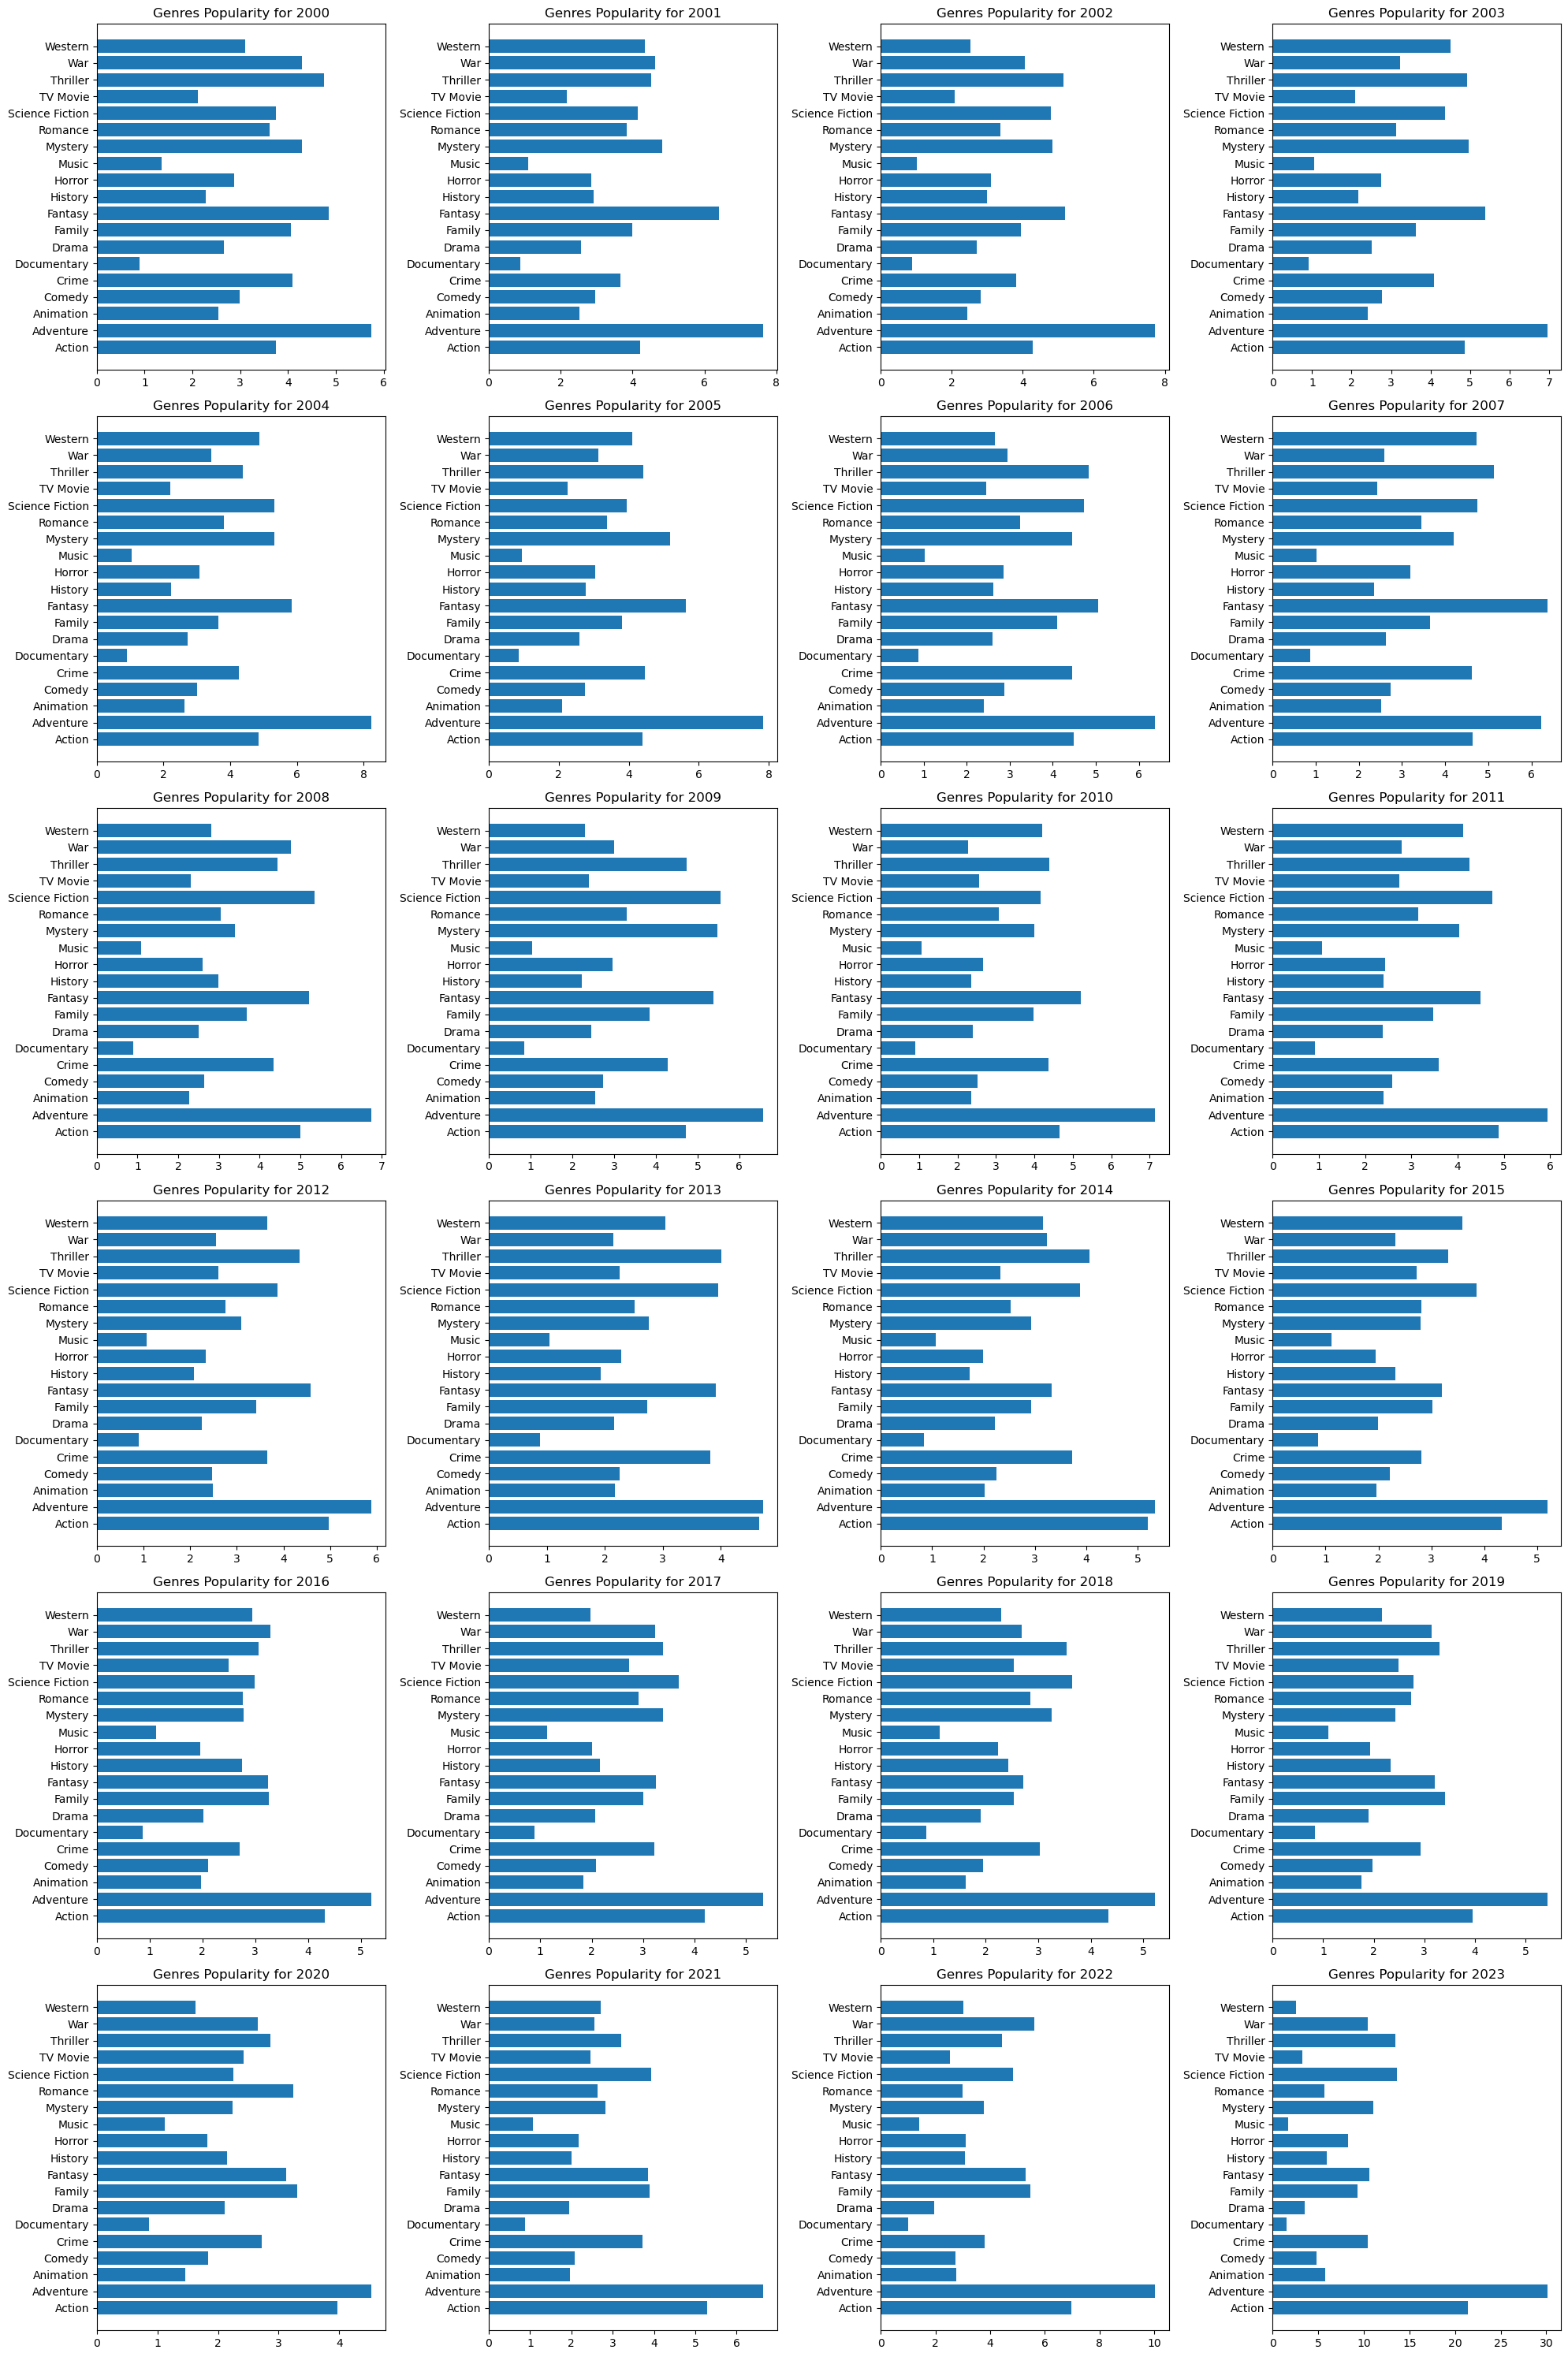

In [19]:
# Creating subplots for each year
fig, axs = plt.subplots(6, 4, figsize=(20, 30))

for i, ax in enumerate(axs.flatten()):
    year = 2000 + i
    df_current_year = df_year[df_year['release_year'] == year]
    genre_counts = df_current_year.groupby('genres')['popularity'].mean()
    
    ax.barh(genre_counts.index, genre_counts.values)
    ax.set_title(f"Genres Popularity for {year}")

plt.tight_layout()
plt.show()

**Nhận xét:**
- Từ năm 2000-2023, phim thuộc thể loại `Adventure` gần như luôn phổ biến nhất ( chỉ trừ năm 2007 là `Fantasty`).
- Có thể thấy rằng phim thuộc thể loại Adventure luôn được yêu thích nhất trong những năm gần đây. Có lẽ điều đó giải thích tại sao gần đây các nhà sản xuất phim lại thích thể loại Adventure hơn những thể loại khác: chúng có độ phổ biến cao hơn các thể loại khác, hiện tại đang là xu hướng.

*Biểu đồ cho thấy sự thay đổi độ phổ biến qua mỗi năm*

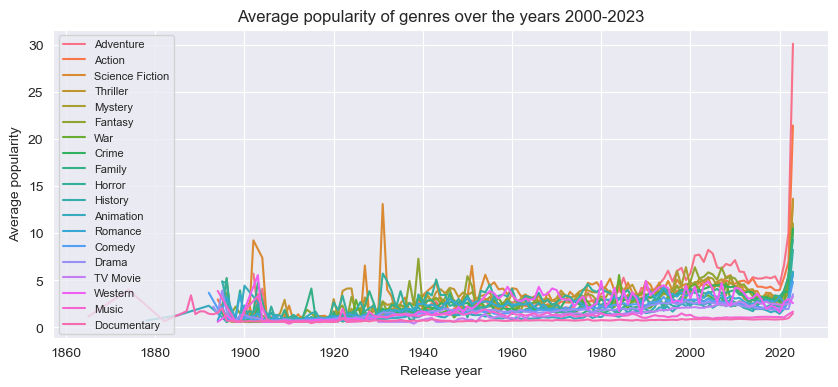

In [20]:
# function for seaborn lineplot to show popularity of genres over the years

def my_lineplot(my_genres_list):
    
    # filter dataframe to contain only wanted genres:
    my_dataframe = df_year[df_year['genres'].isin(my_genres_list)]
    
    # create lineplot
    plt.figure(figsize=(10,4))
    sns.set_style("darkgrid")
    sns.lineplot(data=my_dataframe, x='release_year', y='popularity', hue='genres')
    plt.title('Average popularity of genres over the years 2000-2023')
    plt.xlabel('Release year')
    plt.ylabel('Average popularity')
   
    plt.legend(loc='upper left', fontsize=8);
my_lineplot(df_year['genres'].unique())


**Nhận xét:**
- Có sự thay đổi rõ ràng về mức độ phổ biến của thể loại qua các năm.
- Trong những năm từ 2000 đến nay, độ phổ biến của các phim thuộc thể loại Adventure, Action tăng mạnh.

### **Câu hỏi 3**: 10 nước có tổng số phim nhiều nhất ở TMDB qua từng năm là những nước nào?y<a name="cauhoi_3"></a>

**Ý nghĩa:**
- Việc tìm ra câu trả lời cho câu hỏi này sẽ giúp ta có cái nhìn tổng quan về tình hình các nước trên thế giới và phán đoán khả năng phát triển của Việt Nam:
>*Thế giới*: Mặc dù 10 nước trên có số lượng phim trên Netflix rất cao, và ta sẽ cần xem xét môi trường cạnh tranh khốc liệt như thế nào.  
>*Việt Nam*: Kiểm tra xem Viêt Nam so với thế giới như thế nào, hiểu được việc phim Việt Nam khi ra môi trường thế giới sẽ đối mặt với những vấn đề gì.
- Với việc phân tích này, chúng ta cũng phần nào nắm bắt được thị trường mà TMDB tập trung vào.

**Các bước thực hiện:**
- Đầu tiên ta sẽ lọc ra nước có tổng số phim trên Netflix nhiều nhất rồi từ đó vẽ biểu đồ miền và biểu đồ đường để hiểu rõ mức chênh lệch về tổng số phim để xem tình hình giữa các nước có cạnh tranh như thế nào và TMDB đang chuyển thêm thị trường nào.
- Sau đó mới tiến hành xem xét tình hình sản xuất phim được đánh giá cao ở Việt Nam.

In [21]:
import re
df1 = df.copy()
df1['production_countries']=df1['production_countries'].apply(lambda x:re.split(', |,',str(x)))
#Fix nan thành mảng rỗng
df1['production_countries']=df1['production_countries'].apply(lambda x:[] if str(x)=="['nan']" else x)
df1['production_countries'].head()
top_10_countries = df1['production_countries'].explode().value_counts().head(10)
top_10_countries_df = pd.DataFrame({'Country': top_10_countries.index, 'Count': top_10_countries.values})
top_10_country = top_10_countries_df.loc[:,'Country']
top_10_country

0    United States of America
1                      France
2                     Germany
3              United Kingdom
4                       Japan
5                      Canada
6                       India
7                       Italy
8                      Brazil
9                       Spain
Name: Country, dtype: object

In [22]:
# Ta cần thêm một cột được rút từ cột `release_date` của dữ liệu
df_all = df.copy()
df_all['year_release'] = df_all['release_date'].dt.year
df_all = df_all[(df_all['year_release'] >= 1950) & (df_all['year_release'] <= 2023)]


def DF_unique(x):
    x['production_countries']=x['production_countries'].apply(lambda x:re.split(', |,',str(x)))
    x['production_countries']=x['production_countries'].apply(lambda x:[] if str(x)=="['nan']" else x)
    countries = x['production_countries'].explode().value_counts()
    countries_df = pd.DataFrame({'Country': countries.index, 'Count': countries.values})   
    return countries_df.set_index('Country')
# Chuyển dữ liệu thành bảng bằng cách group theo năm
TMDB_df_all = df_all.groupby(['year_release']).apply(lambda x: DF_unique(x)).unstack(1)

TMDB_df_all.columns = TMDB_df_all.columns.get_level_values(1)

TMDB_df_all = TMDB_df_all.fillna(value=0).astype(np.int32)

TMDB_df = TMDB_df_all.loc[:,top_10_country]
TMDB_df

Country,United States of America,France,Germany,United Kingdom,Japan,Canada,India,Italy,Brazil,Spain
year_release,,,,,,,,,,
1950.0,674,104,89,107,70,18,41,75,16,34
1951.0,665,111,90,125,84,29,40,77,16,28
1952.0,545,105,71,132,102,15,34,100,29,32
1953.0,599,99,118,146,100,18,45,113,15,30
1954.0,478,111,153,153,114,14,50,166,27,46
...,...,...,...,...,...,...,...,...,...,...
2019.0,6805,1826,1250,1581,1449,1307,984,588,959,586
2020.0,6280,1627,1080,1549,1356,1189,703,589,919,590
2021.0,6282,1889,1114,1612,1815,1255,894,632,984,602


*Ta sẽ vẽ biểu đồ miền theo từng năm, do đó ta sẽ đưa chúng về tỷ lệ phần trăm theo từng năm ứng với số lượng phim mỗi nước*

In [23]:
data_perc = TMDB_df.divide(TMDB_df.sum(axis=1), axis=0)
data_perc

Country,United States of America,France,Germany,United Kingdom,Japan,Canada,India,Italy,Brazil,Spain
year_release,,,,,,,,,,
1950.0,0.548860,0.084691,0.072476,0.087134,0.057003,0.014658,0.033388,0.061075,0.013029,0.027687
1951.0,0.525692,0.087747,0.071146,0.098814,0.066403,0.022925,0.031621,0.060870,0.012648,0.022134
1952.0,0.467811,0.090129,0.060944,0.113305,0.087554,0.012876,0.029185,0.085837,0.024893,0.027468
1953.0,0.466875,0.077163,0.091972,0.113796,0.077942,0.014030,0.035074,0.088075,0.011691,0.023383
1954.0,0.364329,0.084604,0.116616,0.116616,0.086890,0.010671,0.038110,0.126524,0.020579,0.035061
...,...,...,...,...,...,...,...,...,...,...
2019.0,0.392558,0.105336,0.072108,0.091203,0.083588,0.075397,0.056764,0.033920,0.055322,0.033804
2020.0,0.395416,0.102443,0.068002,0.097532,0.085380,0.074865,0.044264,0.037086,0.057864,0.037149
2021.0,0.367820,0.110604,0.065226,0.094385,0.106271,0.073482,0.052345,0.037005,0.057615,0.035248


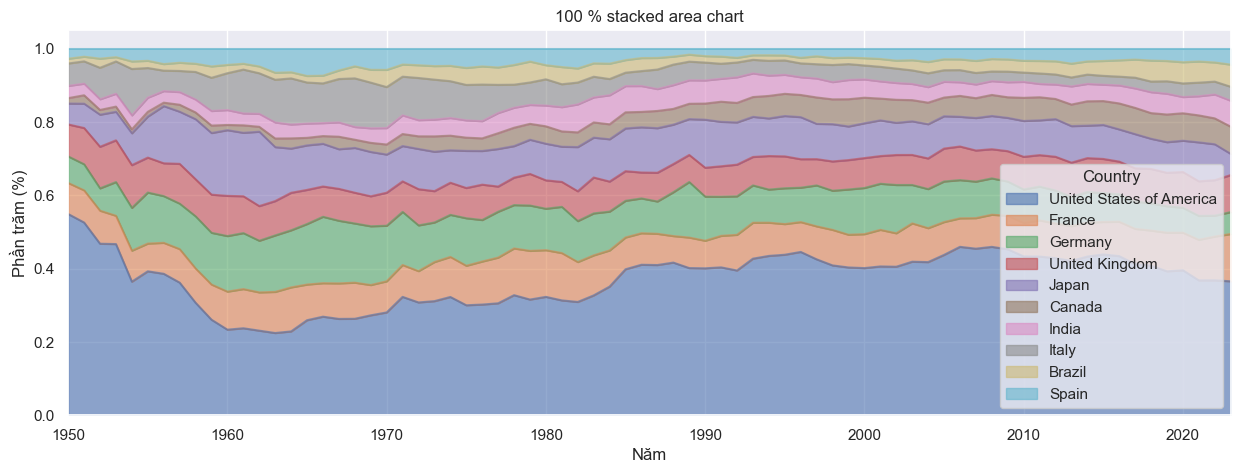

In [24]:
sns.set_theme()

ax = data_perc.plot(kind='area', stacked=True, title='100 % stacked area chart', 
                    figsize=(15,5), alpha=0.6, sharex=True )

ax.set_ylabel('Phần trăm (%)')
ax.set_xlabel('Năm')
ax.margins(0, 0)

plt.show()


**Nhận xét**
- Mỹ (United States of America) là nước có số lượng phim trong TMDB cao hơn  nhiều so với những nước khác qua các năm.
- Các nằm gần đây, thị trường Châu Âu và Châu Á bắt đầu lấn chiếm thị trường Mỹ. Có vẻ từ gần đây, TMDB đã thấy tiềm năng ở các thị trường ở các châu lục này. 


**Tiếp tục phân tích**
- *Để làm rõ sự phát triển về phim của những nước top đầu, ta sẽ tiếp tục tiến hành phân tích tiến trình phát triển mỗi nước*

In [25]:
# Từ bảng các giá trị, ta chuyển về dạng DataFrame để vẽ biểu đồ
TMDB_df_stacked = pd.DataFrame(TMDB_df.stack(0)).reset_index()
TMDB_df_stacked.columns = ['Year','Country','Films']
TMDB_df_stacked

,Year,Country,Films
0,1950.0,United States of America,674
1,1950.0,France,104
2,1950.0,Germany,89
3,1950.0,United Kingdom,107
4,1950.0,Japan,70
...,...,...,...
735,2023.0,Canada,1066
736,2023.0,India,1019
737,2023.0,Italy,548
738,2023.0,Brazil,868


C:\Users\HP\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


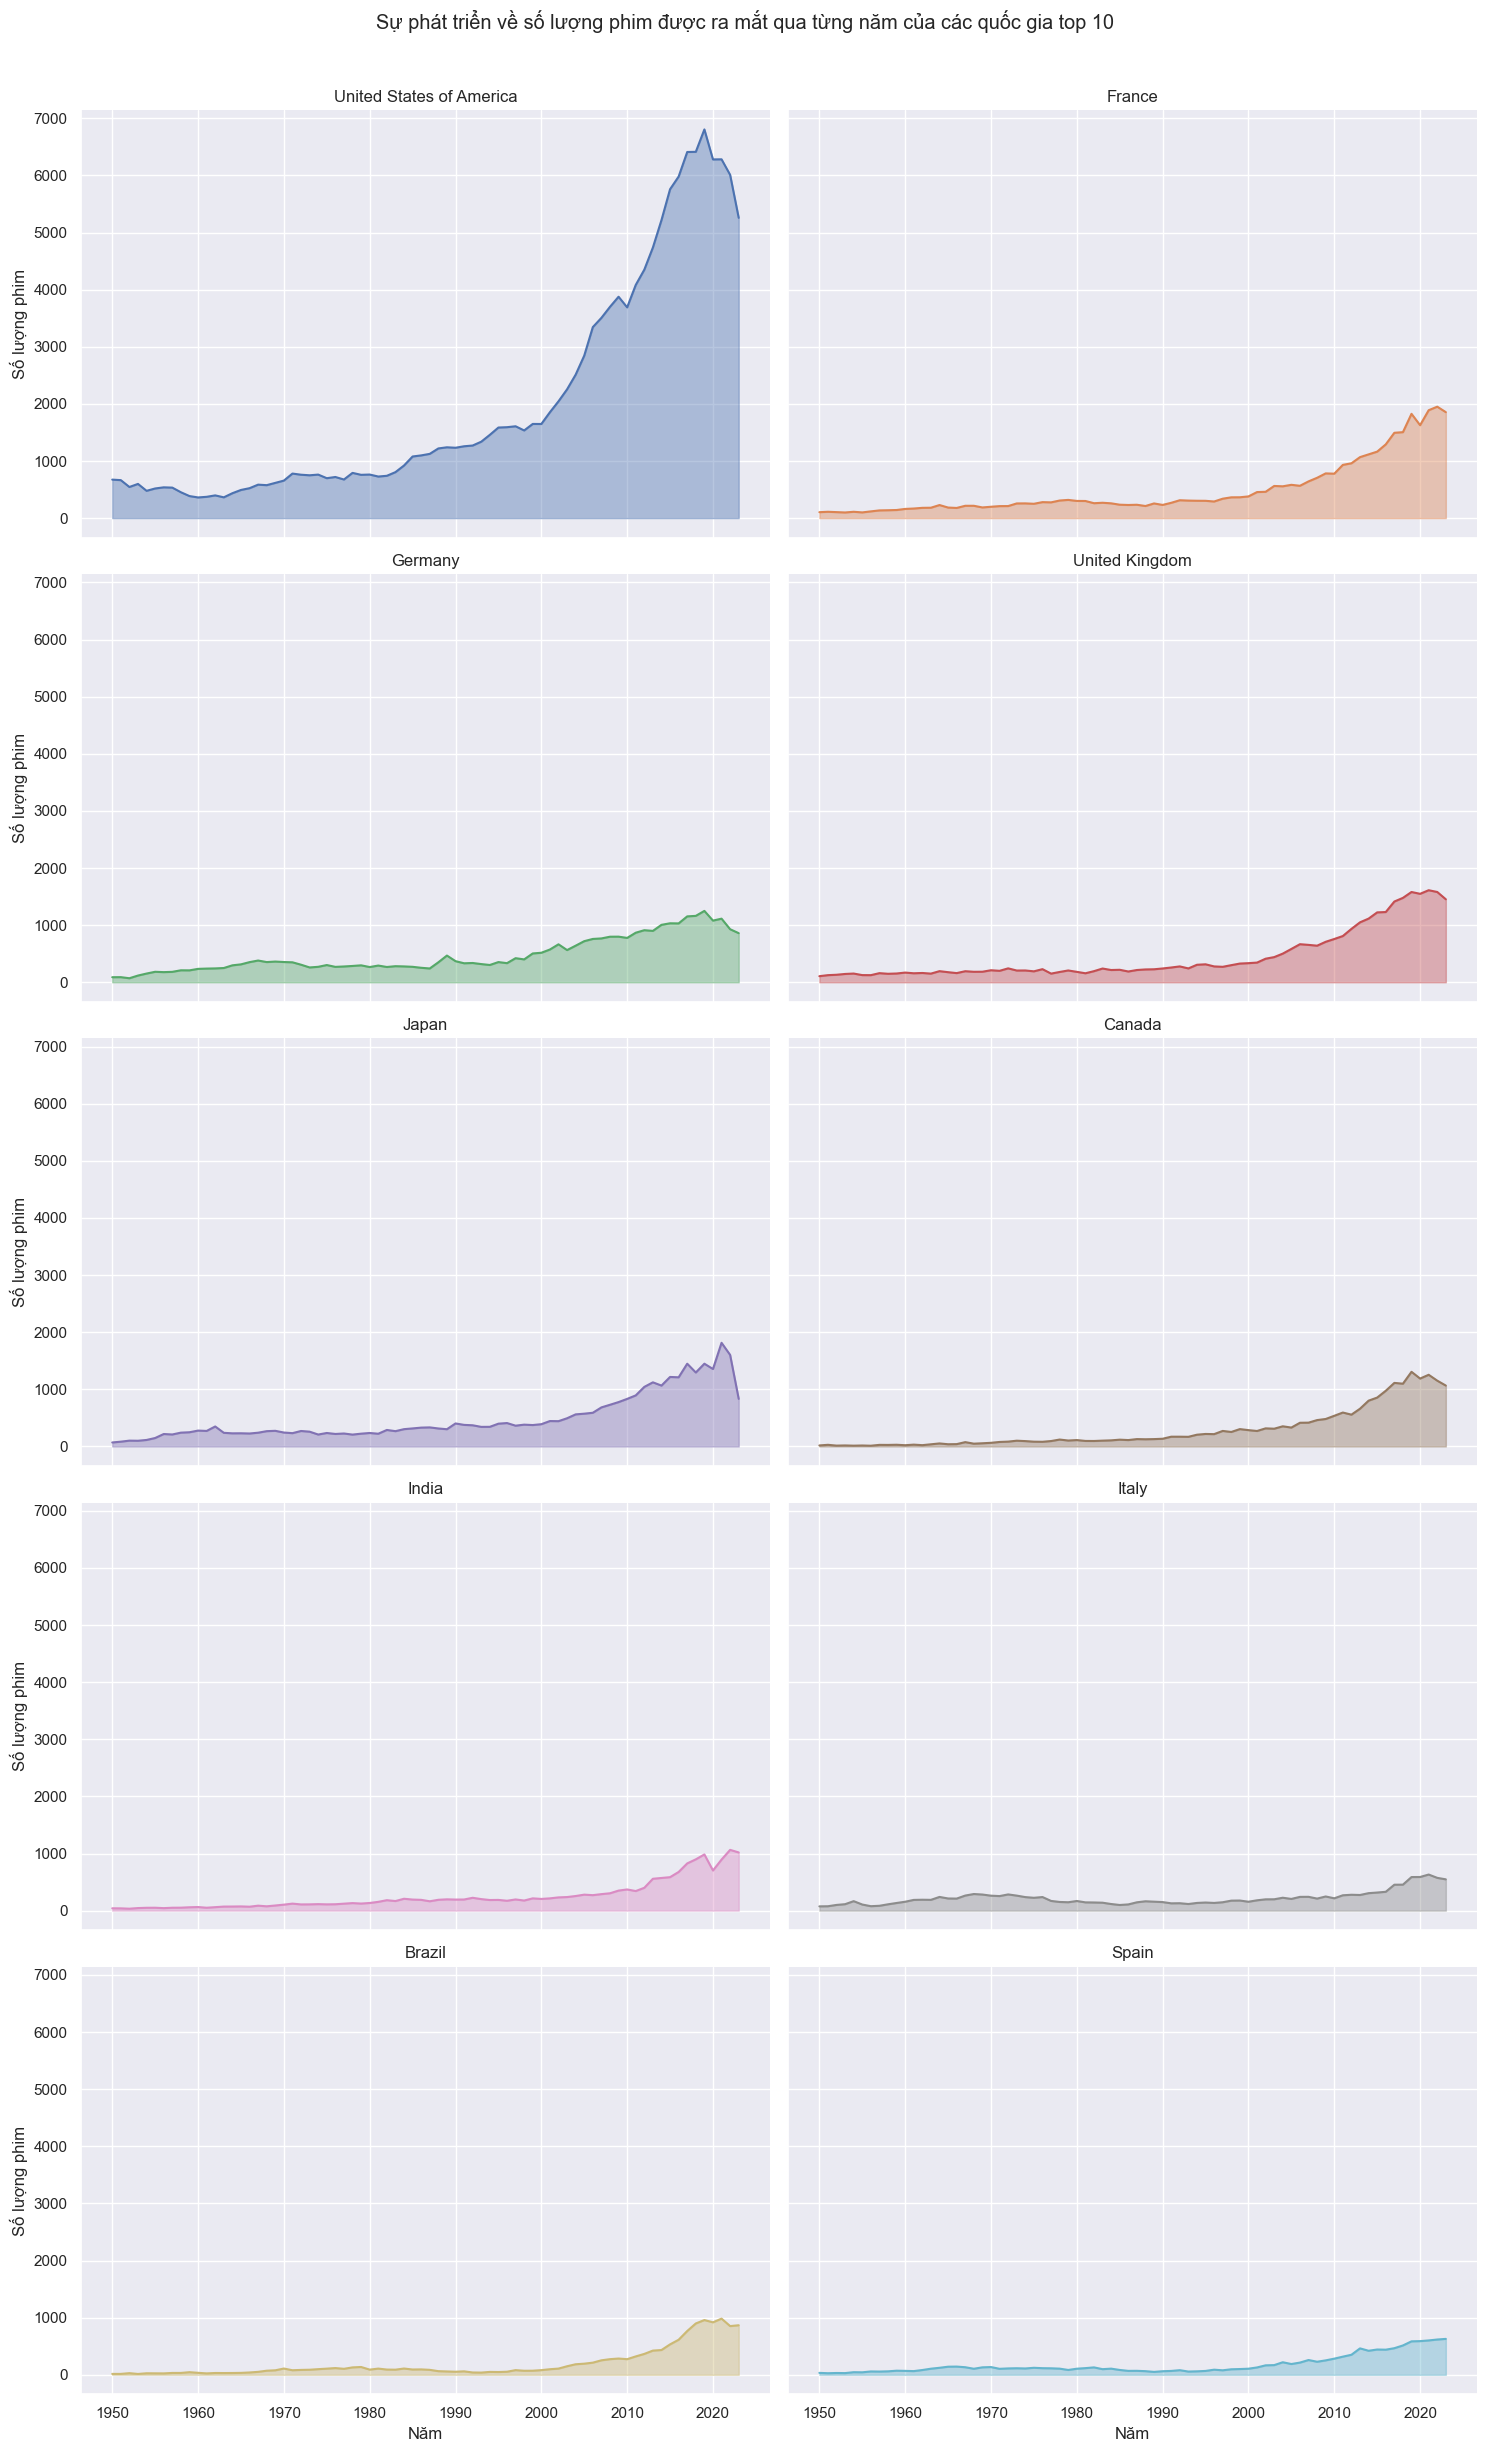

In [26]:
# Khởi tạo grid
g = sns.FacetGrid(TMDB_df_stacked, col='Country', hue='Country', 
                  col_wrap=2, height=5, aspect=1.5)

# Vẽ biểu đồ đường
g = g.map(plt.plot, 'Year', 'Films')

# Tô màu các biểu đồ
g = g.map(plt.fill_between, 'Year', 'Films', alpha=0.4)
 
# Hiệu chỉnh tên từng biểu đồ
g = g.set_titles("{col_name}")
g = g.set_ylabels("Số lượng phim")
g = g.set_xlabels("Năm")

# Thêm tên tổng của các biểu đồ
plt.subplots_adjust(top=0.94)
g = g.fig.suptitle('Sự phát triển về số lượng phim được ra mắt qua từng năm của các quốc gia top 10')

# Vẽ grid 
plt.show()


**Nhận Xét:**
- Các nước  đều có xu hướng tăng số lượng phim được ra mắt trong TMDB.
- Những năm dính Covid là năm khiến nhiều nước lớn giảm sản xuất phim.


**Kiểm tra tình hình Việt Nam:**
- Việt Nam trong thời gian qua thì mảng phim hoạt động khá nhộn nhịp,do đó mục tiêu phần này là muốn xem xem tình hình phát triển của Việt Nam, liệu trong tương lai, Việt Nam có thể phát triển mạnh ở lĩnh vực phim ảnh hay không.

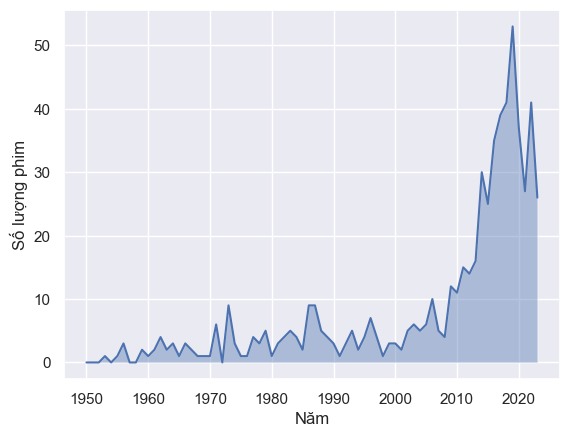

In [27]:
# Kiểm tra tình hình phát triển qua các năm
vietnam_df = TMDB_df_all.loc[:,['Vietnam']]

sns.set_theme(style="darkgrid")

ax = sns.lineplot(data=vietnam_df, x='year_release', y='Vietnam', legend=True)

plt.fill_between(x=vietnam_df.index, y1=vietnam_df.Vietnam.values, alpha=0.4)

ax.set(xlabel='Năm', ylabel='Số lượng phim')

plt.show()


In [28]:
# Các phim được thêm vào Netflix
df1.loc[df1.loc[:,'production_countries'].apply(lambda x: 'Vietnam' in x),
              ['title', 'vote_average', 'status', 'release_date', 'revenue', 
                 'runtime', 'production_countries', 'popularity', 'genres',]]\
        .sort_values(by='release_date')

,title,vote_average,status,release_date,revenue,runtime,production_countries,popularity,genres
673183,A Penny for a Horse,0.0,Released,1924-04-30,0,0,[Vietnam],0.600,Drama
565316,Two Worlds,0.0,Released,1953-01-01,0,61,"[France, Vietnam]",0.600,Drama
477973,Vietnam,0.0,Released,1955-05-01,0,64,"[Soviet Union, Vietnam]",0.600,Documentary
665175,We Want to Live,0.0,Released,1956-01-01,0,95,[Vietnam],0.655,"War, Drama"
455673,Saigon,0.0,Released,1956-04-18,0,0,"[Philippines, Vietnam]",0.600,Drama
...,...,...,...,...,...,...,...,...,...
902101,"La ciel, la terre",0.0,Released,NaT,0,27,"[France, Vietnam]",0.600,NaN
906895,"Mine, Yours",0.0,Released,NaT,0,19,[Vietnam],0.600,Drama
906905,As I Lay Dying,0.0,Released,NaT,0,19,[Vietnam],0.600,NaN
929050,Đám cưới Danh Phương,0.0,Released,NaT,20000,0,[Vietnam],0.600,"Family, Romance"


**Nhận xét**
- Vậy biểu đồ tăng trưởng Việt Nam tương tự như phần đông của thế giới khi phim được thêm vào năm 2017-2019 là nhiều, có thể những năm này, TMDB đánh vào thị trường Việt Nam.
- Số lượng phim Việt Nam ra môi trường ngoài nước là rất ít so với các nước khác, tuy nhiên việc nằm trong danh sách số ít nước có phim  ở TMDB cũng cho thấy khả năng của người Việt như thế nào, có thể trong tương lai sẽ có nhiều nội dung ấn tượng để đưa Việt Nam phát triển mạnh hơn.
- Thị trường Việt Nam cũng được xem là thị trường tiềm năng.

### **Câu hỏi 4**: ghi nội dung ở đây<a name="cauhoi_4"></a>

**Ý nghĩa:**

### **Câu hỏi 5**: ghi nội dung ở đây<a name="cauhoi_5"></a>

**Ý nghĩa:**

# **Phase 5**: Reflection

## 5.0 Team members

**Văn Bá Bảo Huy**
- Khó khăn:
- Điều đã học được:

**Nguyễn Thị Gái**
- Khó khăn:
- Điều đã học được:

**Nguyễn Thị Thanh Hoa**
- Khó khăn:
- Điều đã học được:

## 5.1 Team

Nếu có nhiều thời gian hơn, nhóm sẽ ...